# **East Africa drought study - exploratory analysis**

**Data sources:**

- CHIRPS 0.5deg gridded daily precipitation data, augmented with CenTrends (0.1deg resolution, monthly data)
- National shapefile: https://data.humdata.org/dataset/greater-horn-of-africa-countries
- Gridded elevation data: https://download.gebco.net/
- GPCC drought indices: https://opendata.dwd.de/climate_environment/GPCC/html/gpcc_di_doi_download.html, https://opendata.dwd.de/climate_environment/GPCC/html/gpcc_di_v_1-1_doi_download.html


In [1]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *
from wwa_nonstationary_fitting import *

proj_kw = {"projection" : cartopy.crs.PlateCarree()}

---
## **Pre-processing**

### **Gridded data**

In [26]:
# get monthly CHIRPS data over same region as centrends (will need a larger area for spatial pattern, but this is better to work with)
chirps = xr.open_mfdataset("../../Data/chirps_05/*.nc").sel(longitude = slice(33,51.5), latitude = slice(-5,15))
chirps_m = chirps.resample(time = "MS").sum(skipna = False).assign_attrs(long_name = "Monthly precip", units = "mm")
chirps_m.to_netcdf("data/chirps05_monthly.nc")

In [6]:
# daily data at coarser resolution - used to get seasonal cycle
chirps = xr.open_mfdataset("../../Data/chirps_25/*.nc").sel(longitude = slice(33,51.5), latitude = slice(-5,15))
chirps.to_netcdf("data/chirps25_daily.nc")

In [68]:
cpc = xr.open_mfdataset("../../Data/cpc/precip.*.nc").sel(lon = slice(33,52), lat = slice(15,-5)).resample(time = "MS").sum().assign_attrs(long_name = "Monthly precip", units = "mm")
cpc.to_netcdf("data/cpc_monthly.nc")

# keep tmin, tmax at daily resolution for more accurate estimate of PET
[xr.open_mfdataset("../../Data/cpc/"+varnm+".*.nc").sel(lon = slice(33,52), lat = slice(15,-5)).to_netcdf("data/cpc_"+varnm+".nc") for varnm in ["tmin", "tmax"]]

[None, None]

In [46]:
# # extract necessary data from MSWEP daily files - slow, try to avoid running again
# for y in range(1979, 2021):
#     ds = xr.open_mfdataset("/home/clair/Data/mswep_past/"+str(y)+"*.nc").sel(lon = slice(33,51.5), lat = slice(15,-5)).resample(time = "MS").sum(skipna = False).assign_attrs(long_name = "Monthly precip", units = "mm")
#     ds.to_netcdf("mswep/mswep-monthly_"+str(y)+".nc")
    
# for y in range(2021, 2024):
#     ds = xr.open_mfdataset("/home/clair/Data/mswep_nrt/"+str(y)+"*.nc").sel(lon = slice(33,51.5), lat = slice(15,-5)).resample(time = "MS").sum(skipna = False).assign_attrs(long_name = "Monthly precip", units = "mm")
#     ds.to_netcdf("mswep/mswep-monthly_"+str(y)+".nc")

# xr.open_mfdataset("mswep/*.nc").precipitation.assign_attrs(long_name = "Monthly precip", units = "mm").rename("precip").to_netcdf("data/mswep_monthly.nc")

### **Shapefile for starting region**

In [247]:
# initial shapefile: start by considering GHA region (Kenya, Ethiopia, Somalia) - may reduce this if not homogeneous climatology
sf = gpd.read_file("sf/gha").to_crs(cartopy.crs.PlateCarree()).loc[[3,4,6]].dissolve().explode(index_parts = True)
sf = sf[sf.geometry.area == sf.geometry.area.max()]
sf.to_file("sf_gha")

---
## **Define study region**

In [46]:
chirps = xr.open_dataset("data/chirps05_monthly.nc").precip.assign_attrs(long_name = "Monthly precip", units = "mm/month")
chirps_seasonal = chirps.groupby("time.month").mean()
sf = gpd.read_file("sf_gha")
elev = xr.open_dataset("../90_data/tbase_elev-0.25deg.nc").elev.sel(lon = slice(28,54), lat = slice(-15,18))


### **Elevation**

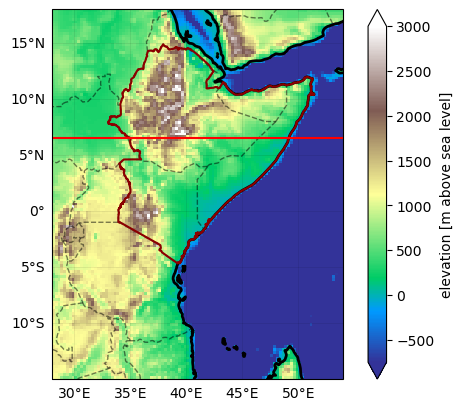

In [47]:
elev.plot(cmap = "terrain", vmin = -750, vmax = 3000, subplot_kws = proj_kw)

ax = plt.gcf().axes[0]
ax.coastlines(lw = 2)
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
sf.boundary.plot(ax = ax, color = "darkred")
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.1)

plt.savefig("fig/elevation.png")

plt.axhline(6.5, color = "red")

### **Investigate regional variations in seasonal cycle**

In [2]:
# seasonal cycle at each latitude - use daily data for this

chirps_d = xr.open_dataset("data/chirps25_daily.nc").precip.assign_attrs(long_name = "Mean precip")

chirps_sc_by_lat = chirps_d.groupby_bins(group = "latitude", bins = range(-5,15)).mean().mean("longitude").groupby("time.dayofyear").mean()
chirps_sc_by_lon = chirps_d.groupby_bins(group = "longitude", bins = range(33,52)).mean().mean("latitude").groupby("time.dayofyear").mean()

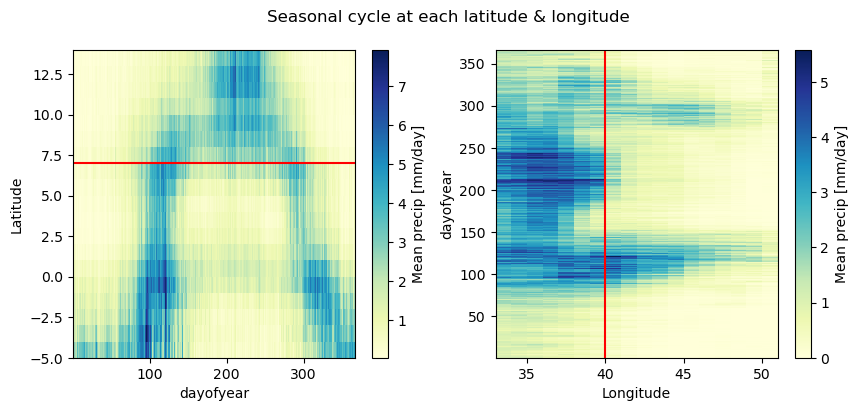

In [40]:
fig, axs = plt.subplots(ncols = 2, figsize = (10,4), dpi = 100)

chirps_sc_by_lat.transpose().plot(ax = axs[0], cmap = "YlGnBu") 
axs[0].set_ylabel("Latitude")
axs[0].axhline(7, color = "red")

chirps_sc_by_lon.plot(ax = axs[1], cmap = "YlGnBu") 
axs[1].set_xlabel("Longitude")
axs[1].axvline(40, color = "red")

plt.suptitle("Seasonal cycle at each latitude & longitude")
plt.savefig("fig/chirps_seasonal-cycle_latlon.png")

In [8]:
# and check each 2x2 grid cell
chirps_sc_ll = chirps_d.groupby_bins(group = "latitude", bins = range(-5,15,2)).mean().groupby_bins(group = "longitude", bins = range(33,52,2)).mean().groupby("time.dayofyear").mean()
chirps_sc_ll = chirps_sc_ll.sortby("latitude_bins", ascending = False)

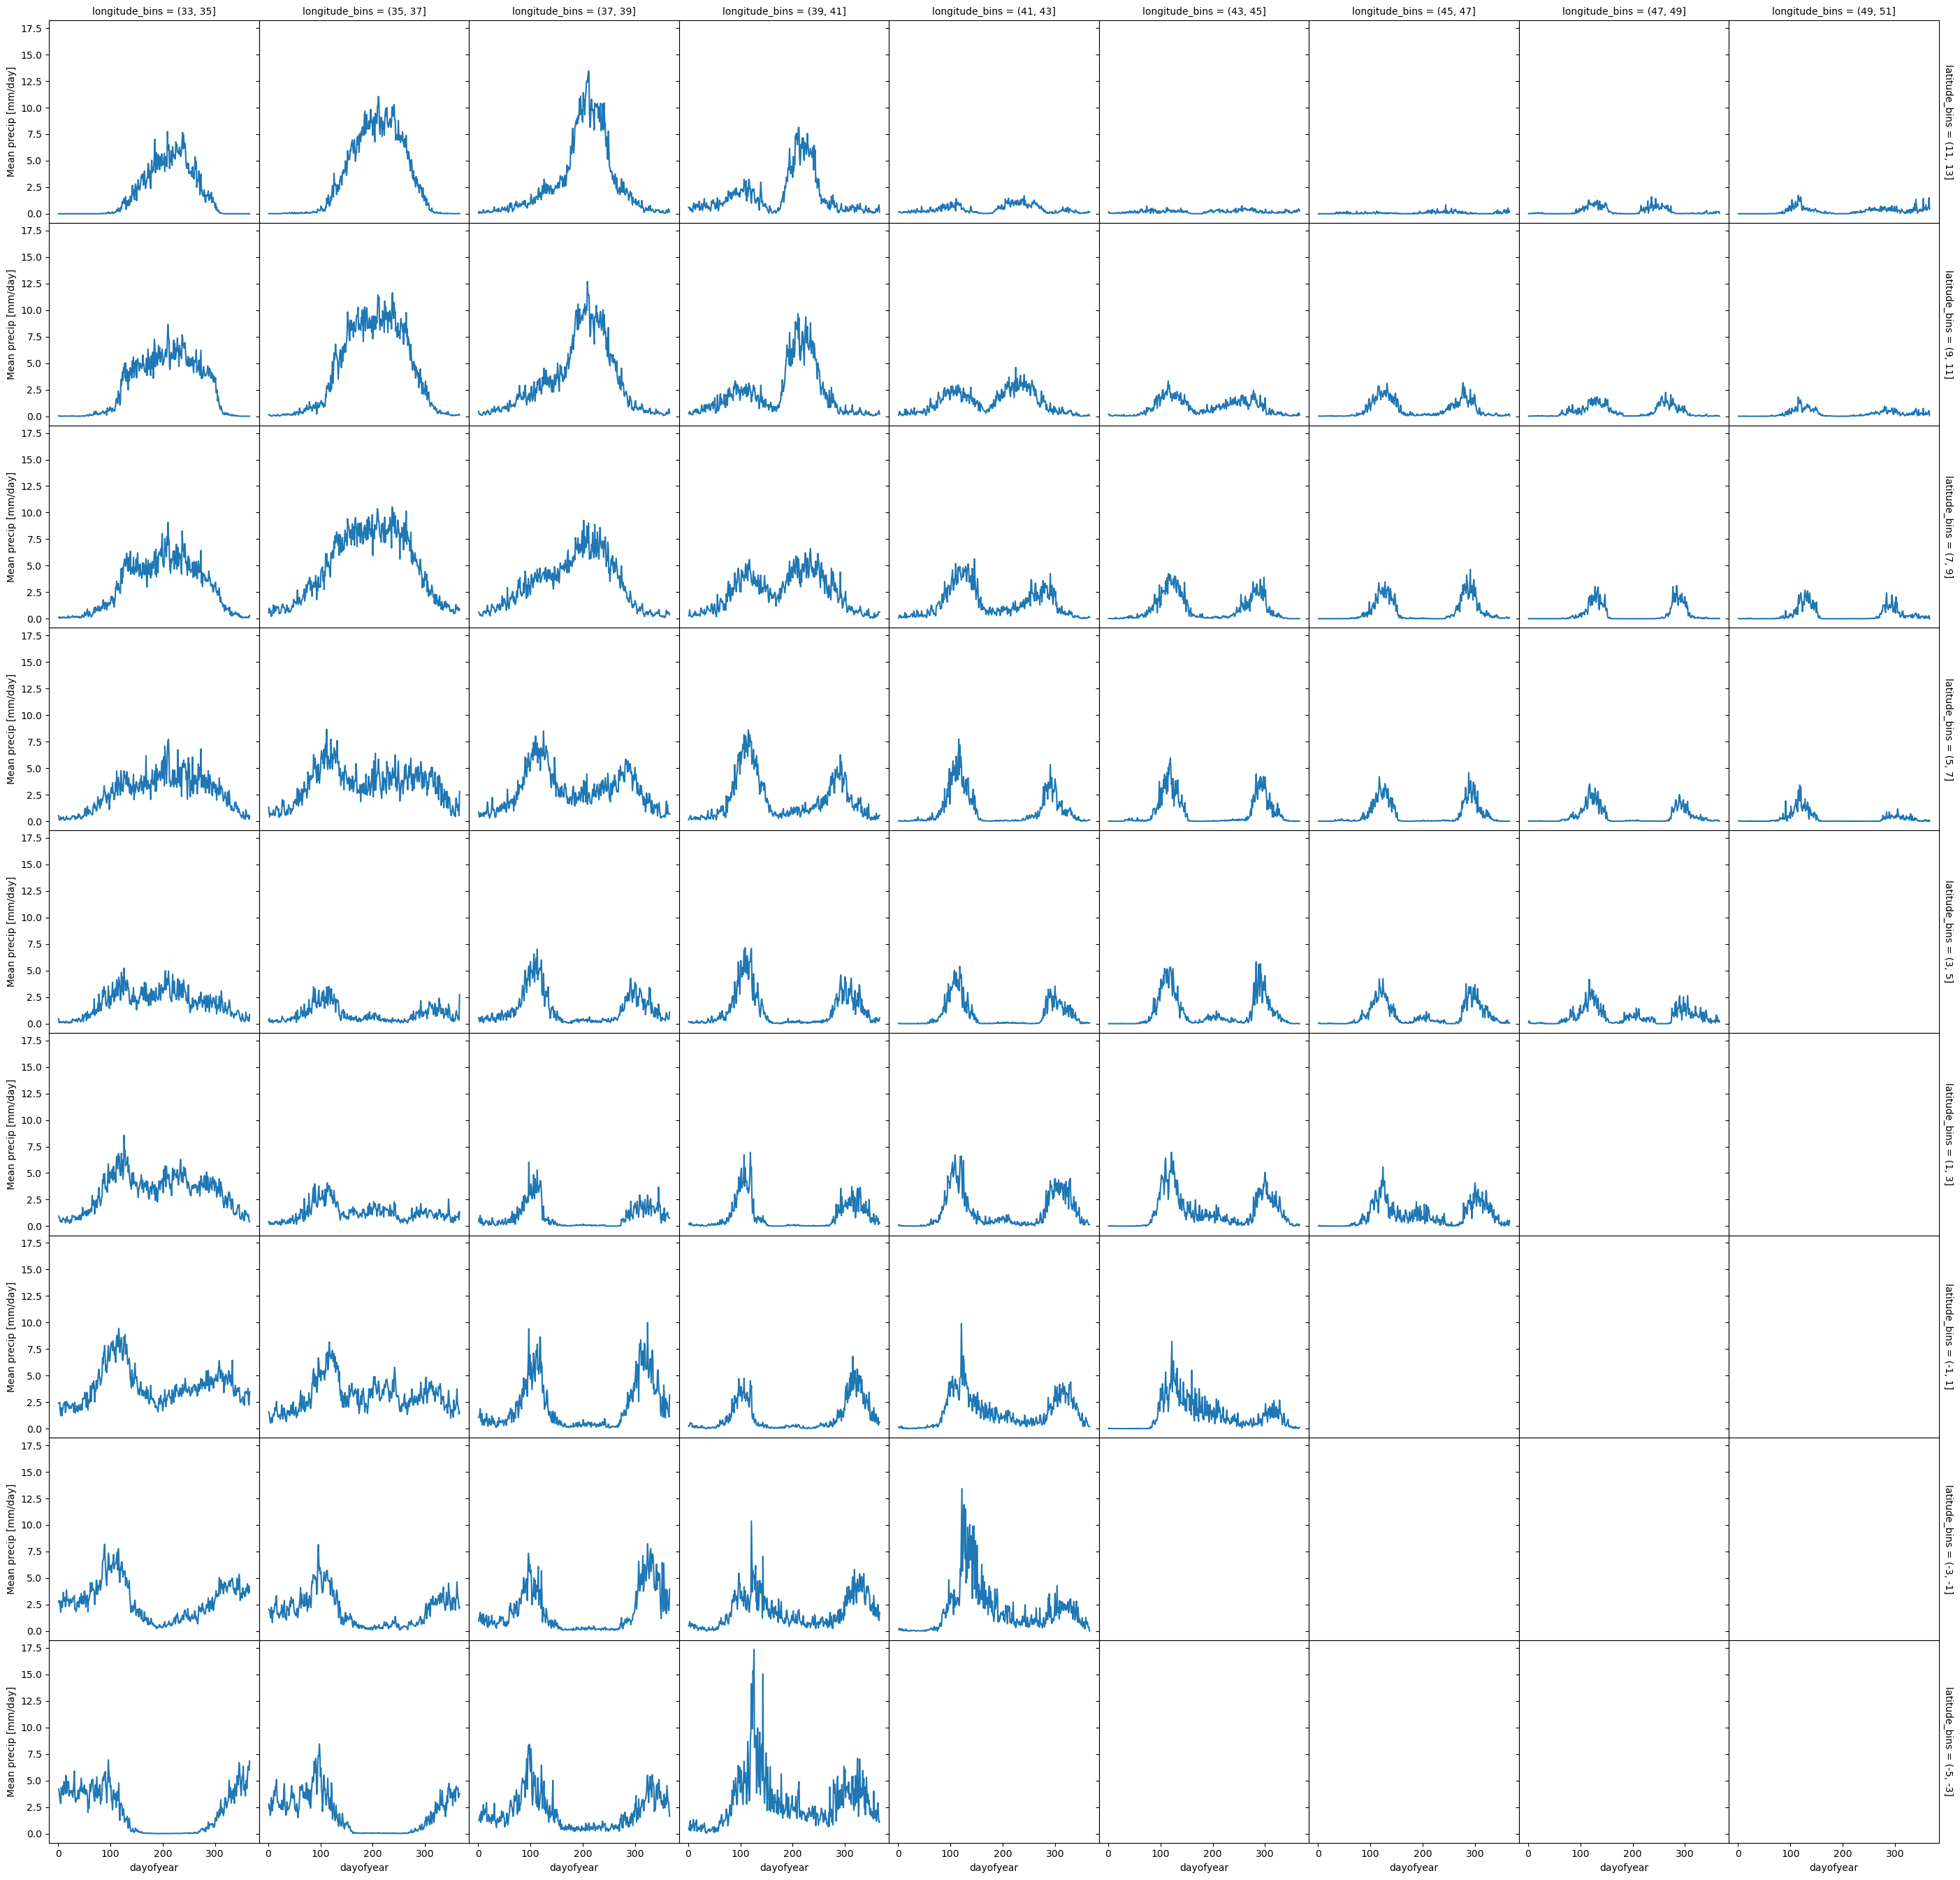

In [9]:
chirps_sc_ll.plot(col = "longitude_bins", row = "latitude_bins")
plt.subplots_adjust(hspace = 0, wspace = 0)
plt.savefig("fig/chirps_seasonal-cycle_grid.png")

### **Candidate region**
_Test homogeneity of region by checking correlation with Kenya mean precipitation_

In [240]:
# create shapefile
sf = gpd.read_file("sf_gha").set_crs(cartopy.crs.PlateCarree()).clip((33, -5, 52, 6.5))
sf.to_file("sf_gha-south")

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/geopandas/tools/clip.py:63: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


In [194]:
chirps_m = xr.open_dataset("data/chirps25_daily.nc").precip.assign_attrs(long_name = "Mean precip").resample(time = "MS").mean()

kenya = gpd.read_file("sf/gha").to_crs(cartopy.crs.PlateCarree()).loc[[4]]
kenya_rm = regionmask.mask_3D_geopandas(kenya, chirps_m.longitude, chirps_m.latitude).squeeze(drop = True)
kenya_ts = chirps_m.where(kenya_rm == 1).mean(["latitude", "longitude"])

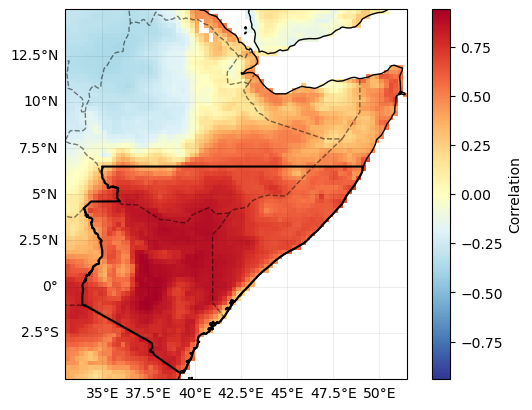

In [241]:
xr.corr(kenya_ts, chirps_m, ["time"]).assign_attrs(long_name = "Correlation", units = "").plot(subplot_kws = proj_kw, cmap = "RdYlBu_r")
ax = plt.gcf().axes[0]
sf.boundary.plot(ax = ax, color = "k")
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)    
ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.1)

plt.savefig("fig/candidate-region.png")

## **Time series for climate explorer**

### **CHIRPS**

#### **Long & short rains**

In [27]:
chirps_m = xr.open_dataset("data/chirps05_monthly.nc").precip
sf = gpd.read_file("sf_gha-south")
rm = regionmask.mask_3D_geopandas(sf, chirps_m.longitude, chirps_m.latitude).squeeze(drop = True)

# monthly time series of 3-month precip over the region
ea_m = chirps_m.where(rm == 1).mean(["latitude", "longitude"]).rolling(time = 3, center = False).sum()

In [22]:
for season in ["mam", "ond"]:
    
    csv_fnm = "ts/EA-drought_pr-"+season+"_chirps05.dat"
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CHIRPS 0.5deg "+season.upper()+" precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr_"+season+" [mm] "+season.upper()+" accumulated precipitation at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr_"+season
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    # get 3-month accumulated precip
    if season == "mam":
        pr = ea_m.groupby("time.month")[5]
    elif season == "ond":
        pr = ea_m.groupby("time.month")[12]
        
    pr.assign_coords(time = pr.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **24-month accumulated**

In [34]:
chirps = xr.open_dataset("data/chirps05_monthly.nc").precip
sf = gpd.read_file("sf_gha-south")
rm = regionmask.mask_3D_geopandas(sf, chirps.longitude, chirps.latitude).squeeze(drop = True)
chirps_m = chirps_m.where(rm == 1).mean(["latitude", "longitude"])


In [93]:
for m in ["24","36"]:
    
    csv_fnm = "ts/EA-drought_pr"+m+"_chirps05.dat"
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CHIRPS 0.5deg "+m+"m accumulated precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr"+m+" [mm/month] 2-year mean precipitation (Jan-Dec) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr"+m
    
    strx = "# CenTrends used prior to 1981: CHIRPS from 1981 onwards"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$strx " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    prx = chirps_m.rolling(time = int(m)).mean().groupby("time.month")[12].dropna("time", "any")
    prx.assign_coords(time = prx.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **CHIRPS + CenTrends**

#### **Long & short rains**

In [28]:
# CenTrends - also get monthly time series over the region
ct = xr.open_dataset("../../Data/CenTrends_v1_monthly.nc")
rm_ct = regionmask.mask_3D_geopandas(sf, ct.longitude, ct.latitude).squeeze(drop = True)

ct_m = ct.precip.where(rm_ct == 1).mean(["latitude", "longitude"]).rolling(time = 3, center = False).sum()

ct_mam = ct_m.groupby("time.month")[5]; ct_ond = ct_m.groupby("time.month")[12]
ea_mam = ea_m.groupby("time.month")[5]; ea_ond = ea_m.groupby("time.month")[12]

Text(0.5, 1.0, 'OND precip')

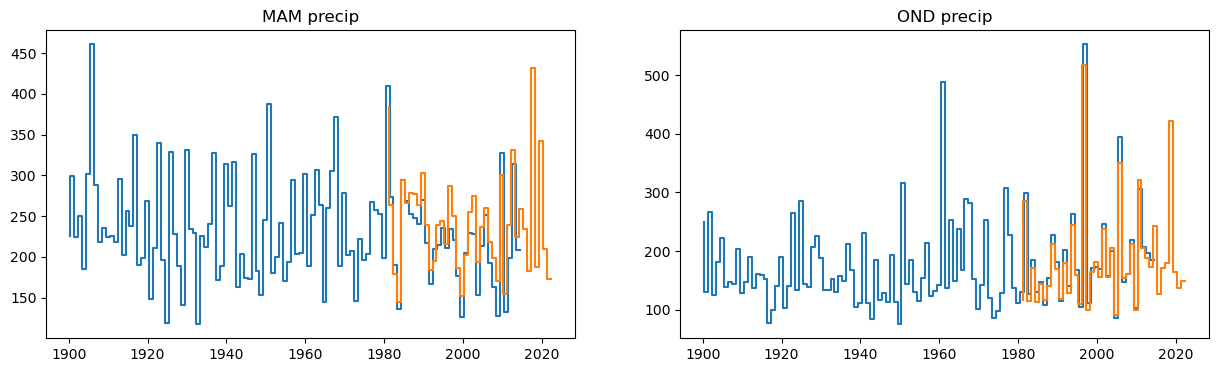

In [29]:
fig, axs = plt.subplots(ncols = 2, figsize = (15,4), dpi = 100)

axs[0].step(ct_mam.time, ct_mam, label = "CenTrends")
axs[0].step(ea_mam.time, ea_mam, label = "CHIRPS")
axs[0].set_title("MAM precip")

axs[1].step(ct_mam.time, ct_ond, label = "CenTrends")
axs[1].step(ea_mam.time, ea_ond, label = "CHIRPS")
axs[1].set_title("OND precip")

In [30]:
pr_mam = xr.concat([ct_mam.sel(time = slice(None, ea_mam.time.min())), ea_mam], "time")
pr_ond = xr.concat([ct_ond.sel(time = slice(None, ea_ond.time.min())), ea_ond], "time")

In [31]:
for season in ["mam", "ond"]:
    
    csv_fnm = "ts/EA-drought_pr-"+season+"_chirps05+centrends01.dat"
    if len(csv_fnm) >= 65: print("! Filename too long: ", csv_fnm)
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CHIRPS 0.5deg + CenTrends 0.1deg "+season.upper()+" precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr_"+season+" [mm] "+season.upper()+" accumulated precipitation at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr_"+season
    
    strx = "# CenTrends used prior to 1981: CHIRPS from 1981 onwards"

    ! echo "$str1 " > $csv_fnm
    ! echo "$strx " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    pr = eval("pr_"+season)
    pr.assign_coords(time = pr.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

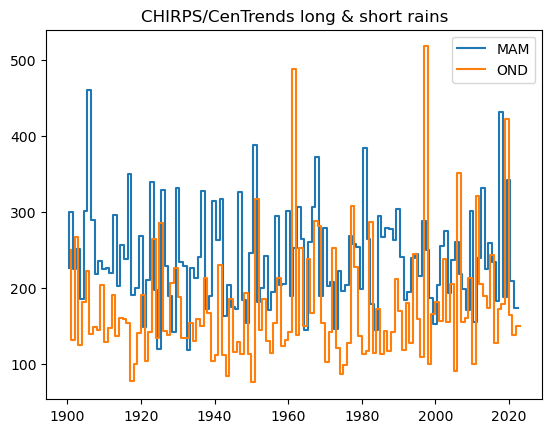

In [32]:
plt.step(pr_mam.time, pr_mam, label = "MAM")
plt.step(pr_ond.time, pr_ond, label = "OND")
plt.legend()
plt.title("CHIRPS/CenTrends long & short rains")
plt.savefig("fig/chirps_timeseries.png")

#### **24-month accumulated**

In [34]:
chirps = xr.open_dataset("data/chirps05_monthly.nc").precip
sf = gpd.read_file("sf_gha-south")
rm = regionmask.mask_3D_geopandas(sf, chirps.longitude, chirps.latitude).squeeze(drop = True)
chirps_m = chirps_m.where(rm == 1).mean(["latitude", "longitude"])

ct = xr.open_dataset("../../Data/CenTrends_v1_monthly.nc")
rm_ct = regionmask.mask_3D_geopandas(sf, ct.longitude, ct.latitude).squeeze(drop = True)

ct_m = ct.precip.where(rm_ct == 1).mean(["latitude", "longitude"])

# combined monthly time series
pr_m = xr.concat([ct_m.sel(time = slice(None, chirps_m.time.min())), chirps_m], "time")

In [35]:
for m in ["24","36"]:
    
    csv_fnm = "ts/EA-drought_pr"+m+"_chirps05+centrends01.dat"
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CHIRPS 0.5deg + CenTrends 0.1deg "+m+"m accumulated precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr"+m+" [mm/month] 2-year mean precipitation (Jan-Dec) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr"+m
    
    strx = "# CenTrends used prior to 1981: CHIRPS from 1981 onwards"
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$strx " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    prx = pr_m.rolling(time = int(m)).mean().groupby("time.month")[12].dropna("time", "any")
    prx.assign_coords(time = prx.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

<AxesSubplot: xlabel='year'>

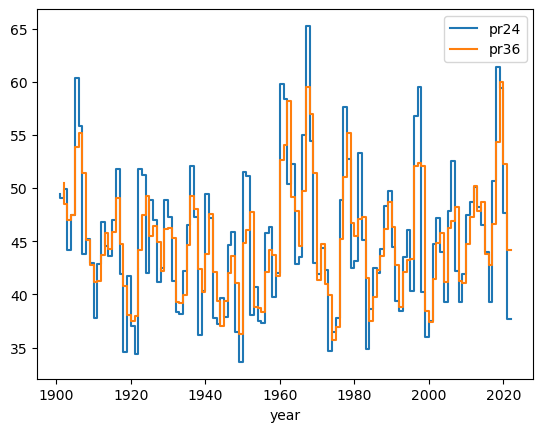

In [36]:
pr24, pr36 = [pd.read_csv("ts/EA-drought_pr"+m+"_chirps05+centrends01.dat", comment = "#", sep = " ", names = ["year", "pr"+m], index_col = 0) for m in ["24", "36"]]
pr24.plot(drawstyle = "steps")
pr36.plot(drawstyle = "steps", ax = plt.gcf().axes[0])

### **CPC**

In [101]:
cpc = xr.open_dataset("data/cpc_monthly.nc").precip

sf = gpd.read_file("sf_gha-south")
rm = regionmask.mask_3D_geopandas(sf, cpc.lon, cpc.lat).squeeze(drop = True)

cpc = cpc.where(rm == 1).mean(["lat", "lon"])
cpc_3m = cpc.rolling(time = 3, center = False).sum()

In [102]:
# long & short rains

for season in ["mam", "ond"]:
    
    csv_fnm = "ts/EA-drought_pr-"+season+"_cpc.dat"
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CPC "+season.upper()+" precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr_"+season+" [mm] "+season.upper()+" accumulated precipitation at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr_"+season
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    # get 3-month accumulated precip
    if season == "mam":
        pr = cpc_3m.groupby("time.month")[5]
    elif season == "ond":
        pr = cpc_3m.groupby("time.month")[12]
        
    pr.assign_coords(time = pr.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

In [103]:
# 2- & 3-year accumulation
for m in ["24","36"]:
    
    csv_fnm = "ts/EA-drought_pr"+m+"_cpc.dat"
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: CPC "+m+"m accumulated precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr"+m+" [mm/month] 2-year mean precipitation (Jan-Dec) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr"+m
        
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    prx = cpc.rolling(time = int(m)).mean().groupby("time.month")[12].dropna("time", "any")
    prx.assign_coords(time = prx.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **MSWEP**

In [111]:
mswep = xr.open_dataset("data/mswep_monthly.nc").precip

sf = gpd.read_file("sf_gha-south")
rm = regionmask.mask_3D_geopandas(sf, mswep.lon, mswep.lat).squeeze(drop = True)

mswep = mswep.where(rm == 1).mean(["lat", "lon"])
pr_3m = mswep.rolling(time = 3, center = False).sum()

In [112]:
# long & short rains

for season in ["mam", "ond"]:
    
    csv_fnm = "ts/EA-drought_pr-"+season+"_mswep.dat"
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: MSWEP "+season.upper()+" precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr_"+season+" [mm] "+season.upper()+" accumulated precipitation at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr_"+season
    
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    # get 3-month accumulated precip
    if season == "mam":
        pr = pr_3m.groupby("time.month")[5]
    elif season == "ond":
        pr = pr_3m.groupby("time.month")[12]
        
    pr.assign_coords(time = pr.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

In [113]:
# 2- & 3-year accumulation
for m in ["24","36"]:
    
    csv_fnm = "ts/EA-drought_pr"+m+"_mswep.dat"
    
    # create extra header lines for upload to Climate Explorer 
    str1 = "# contact :: MSWEP "+m+"m accumulated precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# pr"+m+" [mm/month] 2-year mean precipitation (Jan-Dec) at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year pr"+m
        
    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    prx = mswep.rolling(time = int(m)).mean().groupby("time.month")[12].dropna("time", "any")
    prx.assign_coords(time = prx.time.dt.year).to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

### **Compare time series**

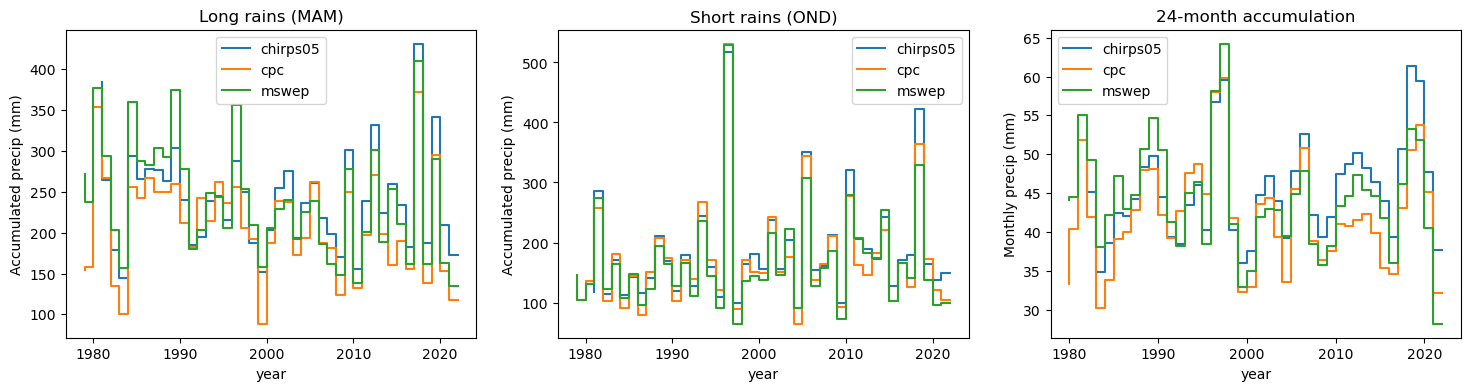

In [118]:
fig, axs = plt.subplots(ncols = 3, figsize = (18,4), dpi = 100)

for ds in ["chirps05", "cpc", "mswep"]:
    
    pd.read_csv("ts/EA-drought_pr-mam_"+ds+".dat", comment = "#", sep = " ", names = ["year", ds], index_col = 0).plot(ax = axs[0], drawstyle = "steps")
    axs[0].set_title("Long rains (MAM)")
    axs[0].set_ylabel("Accumulated precip (mm)")
    
    pd.read_csv("ts/EA-drought_pr-ond_"+ds+".dat", comment = "#", sep = " ", names = ["year", ds], index_col = 0).plot(ax = axs[1], drawstyle = "steps")
    axs[1].set_title("Short rains (OND)")
    axs[1].set_ylabel("Accumulated precip (mm)")
 
    pd.read_csv("ts/EA-drought_pr24_"+ds+".dat", comment = "#", sep = " ", names = ["year", ds], index_col = 0).plot(ax = axs[2], drawstyle = "steps")
    axs[2].set_title("24-month accumulation")
    axs[2].set_ylabel("Monthly precip (mm)")

plt.savefig("fig/gridded-precip-timeseries.png")

---
## **SPI**

In [148]:
nmonths = 3

for ds in ["chirps05", "cpc", "mswep"]:
    
    pr = xr.open_dataset("data/"+ds+"_monthly.nc").precip.rolling(time = nmonths, center = False).sum(keep_attrs = False).dropna("time", "all")
    pr = pr.where(pr > 0, 0).where(pr.sum("time") > 0)
    
    pr_cal = pr.sel(time = slice("1980", "2010")).copy()
    
    spi = xr.concat([xr.apply_ufunc(lambda pr, dparams : norm.ppf(gamma.cdf(pr, *dparams)),
                         pr.groupby("time.month")[m], 
                         fit(pr_cal.groupby("time.month")[m].dropna("time", "all"), dist = "gamma", method = "PWM"), 
                         input_core_dims = [["time"],["dparams"]], output_core_dims = [["time"]], vectorize = True).assign_coords(time = pr.groupby("time.month")[m].time) for m in [5,12]],
                "time").sortby("time").rename("spi")
    
    spi.to_netcdf("data/"+ds+"_spi"+str(nmonths).rjust(2, "0")+".nc")

/home/clair/miniconda3/envs/wwa/lib/python3.10/site-packages/lmoments3/__init__.py:179: RuntimeWarning: invalid value encountered in double_scalars
  l3 = coefl3 * sum_xtrans / l2


ValueError: L-Moments invalid

---
## **Drought classification maps**

### **GPCC**

In [82]:
gpcc = xr.concat([decode_times(xr.open_dataset(fnm, decode_times = False)) for fnm in sorted(glob.glob("../../Data/gpcc/*.nc"))], "time").sel(lon = slice(33,52), lat = slice(-5,15))
sf = gpd.read_file("sf_gha-south")

In [83]:
for n in [1,3,6,12,24,48]:
    
    fig, axs = plt.subplots(ncols = 3, figsize = (10,4), dpi = 100, subplot_kw = proj_kw)
    
    for i in range(3):
        
        ax = axs[i]
        
        cbar = drought_map(gpcc["di_"+str(n).rjust(2, "0")].isel(time = i), ax = ax)
                
        ax.coastlines()
        sf.boundary.plot(ax = ax, color = "darkblue", lw = 2)    
        ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
        ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1)
        
    axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0)
            
    drought_colorbar(cbar, axs, fraction = 0.05, label = str(n)+"-month drought classification")
    
    plt.suptitle("GPCC "+str(n)+"-month drought index", fontweight = "bold")
    
    plt.savefig("fig/spi_gpcc-di"+str(n).rjust(2, "0")+".png"); plt.close()

### **CHIRPS**

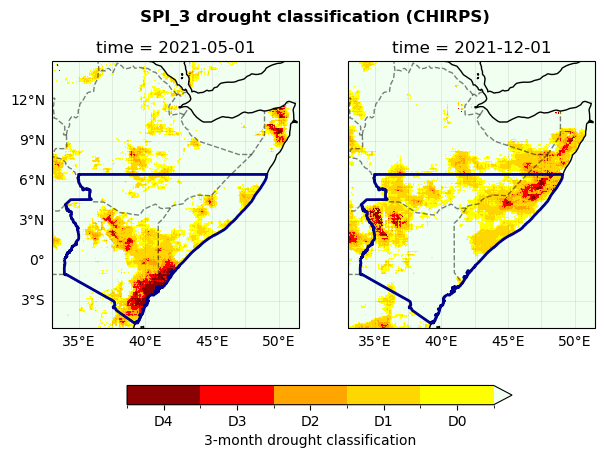

In [50]:
spi3 = xr.open_dataset("data/spi03_chirps05.nc").spi
sf = gpd.read_file("sf_gha-south")

fig, axs = plt.subplots(ncols = 2, figsize = (7,5), dpi = 100, subplot_kw = proj_kw)

drought_map(spi.sel(time = "2021-05"), ax = axs[0])
cbar = drought_map(spi_ond.sel(time = "2021-12"), ax = axs[1])
drought_colorbar(cbar, axs, fraction = 0.05, label = "3-month drought classification")

for ax in axs:
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "darkblue", lw = 2)    
    ax.add_feature(cartopy.feature.BORDERS, ls = "--", alpha = 0.5)
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom"], alpha=0.1)
    
axs[0].gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["left"], alpha=0)

plt.suptitle("SPI_3 drought classification (CHIRPS)", fontweight = "bold", y = 0.9)

plt.savefig("fig/chirps_spi3-drought-classification.png")